In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE # wrapper method pour choisir les features
from sklearn.linear_model import RidgeClassifierCV

import pandas as pd
import numpy as np
import mlflow


In [2]:
df_train= pd.read_feather("../../datasets/train_2.feather")
df_test = pd.read_feather("../../datasets/test_2.feather")

train

Transformation des valeurs manquantes en moyenne

train

In [3]:
count_col = 0
for col in df_train.columns : 
    if df_train[col].dtype =='object': #si de type objet, compter le nombre de valeurs manquantes
        print(col, df_train[col].isna().sum())
    if df_train[col].dtype !='object': #que les valeurs numériques
        if df_train[col].isna().any(): # si valeurs mqtes
            df_train[col] = df_train[col].fillna(df_train[col].mean()) #mettre la moyenne 
            count_col+=1
            #faire comparaison ancien et nouvelle valeurs v2, voir si modification de la distribution

NAME_CONTRACT_TYPE 0
CODE_GENDER 0
FLAG_OWN_CAR 0
FLAG_OWN_REALTY 0
NAME_TYPE_SUITE 1292
NAME_INCOME_TYPE 0
NAME_EDUCATION_TYPE 0
NAME_FAMILY_STATUS 0
NAME_HOUSING_TYPE 0
WEEKDAY_APPR_PROCESS_START 0
ORGANIZATION_TYPE 0


Suppression des lignes ou il y a des valeurs manquantes

In [4]:
df_train.shape

(307511, 72)

In [5]:
df_train.dropna(subset = ['NAME_TYPE_SUITE'],inplace=True, axis = 0) #suppresion des lignes ou il ya des valeurs manquantes

In [6]:
df_train.shape

(306219, 72)

test

In [7]:
count_col = 0
for col in df_test.columns : 
    if df_test[col].dtype =='object': #si de type objet, compter le nombrede valeurs manquantes
        print(col, df_test[col].isna().sum())
    if df_test[col].dtype !='object': #que les valeurs numériques
        if df_test[col].isna().any(): # si valeurs mqtes
            df_test[col] = df_test[col].fillna(df_test[col].mean()) #mettre la moyenne 
            count_col+=1
            #faire comparaison ancien et nouvelle valeurs v2, voir si modification de la distribution

NAME_CONTRACT_TYPE 0
CODE_GENDER 0
FLAG_OWN_CAR 0
FLAG_OWN_REALTY 0
NAME_TYPE_SUITE 911
NAME_INCOME_TYPE 0
NAME_EDUCATION_TYPE 0
NAME_FAMILY_STATUS 0
NAME_HOUSING_TYPE 0
WEEKDAY_APPR_PROCESS_START 0
ORGANIZATION_TYPE 0


Suppression des ligne sou il y a des valeurs manquantes pour la variable name_type_suite

In [8]:
df_test.dropna(subset = ['NAME_TYPE_SUITE'],inplace= True, axis = 0) #suppresion des ligne sou il ya des valeurs manquantes

In [9]:
df_test.isna().sum().sort_values(ascending=True)

SK_ID_CURR                    0
FLAG_DOCUMENT_7               0
FLAG_DOCUMENT_6               0
FLAG_DOCUMENT_5               0
FLAG_DOCUMENT_4               0
                             ..
FLAG_EMP_PHONE                0
FLAG_MOBIL                    0
DAYS_ID_PUBLISH               0
FLAG_EMAIL                    0
AMT_REQ_CREDIT_BUREAU_YEAR    0
Length: 71, dtype: int64

Sép du dataset train de base

Get_dummies variabes catégoriques

Test pour vérifier que c'est le nombre que l'on devrait trouver

unique_count = 0
list_count = [ unique_count := unique_count+ df_train[col].nunique() for col in df_train.select_dtypes('object').columns] #vérification que meme nombre que colonnes rajoutées
col_dum_train = pd.get_dummies(df_train.select_dtypes('object'))
len(df_train.select_dtypes('object').columns)== len(list_count)

In [10]:
df_train.drop(df_train[df_train['CODE_GENDER']=='XNA'].index,axis=0, inplace = True)
df_train.shape #confirmation de la suppression des 4 lignes

(306215, 72)

In [11]:
def encoding(df) :
    unique_count = 0
    list_count = [ (col,unique_count := unique_count+ df[col].nunique()) for col in df.select_dtypes('object').columns] #vérification que meme nombre que colonnes rajoutées
    return  list_count ,pd.get_dummies(df.select_dtypes('object'))

In [12]:
df_test.shape, df_train.shape

((47833, 71), (306215, 72))

cols_train , new_df_train = encoding(df_test) #col a supp + col dummed

In [13]:
cols_test , new_df_test = encoding(df_test)
cols_train , new_df_train = encoding(df_train)

In [14]:
new_df_test = pd.concat([new_df_test,df_test], axis=1)
new_df_train = pd.concat([new_df_train,df_train], axis=1)
new_df_test.shape,new_df_train.shape

((47833, 174), (306215, 176))

Suppression colonnes d'origine qui ont été encodées

In [15]:
new_df_test.drop([cols[0] for cols in cols_test],axis=1, inplace = True)
new_df_train.drop([cols[0] for cols in cols_train],axis=1, inplace = True)
new_df_test.shape,new_df_train.shape

((47833, 163), (306215, 165))

Export new_df_test => sera utilisé pour la prédiction du modele avec fastapi

Prediction template

In [311]:
X_train.columns

Index(['NAME_CONTRACT_TYPE_Cash loans', 'NAME_CONTRACT_TYPE_Revolving loans',
       'CODE_GENDER_F', 'CODE_GENDER_M', 'FLAG_OWN_CAR_N', 'FLAG_OWN_CAR_Y',
       'FLAG_OWN_REALTY_N', 'FLAG_OWN_REALTY_Y', 'NAME_TYPE_SUITE_Children',
       'NAME_TYPE_SUITE_Family',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=164)

In [302]:
pd.Series(X_train.columns.values).to_csv('../../datasets/X_columns_template.csv', index = False)

In [296]:
template_test = pd.DataFrame(data=dict(zip(new_df_test.columns,
                                           np.array([[0] for x in range(len(new_df_test.columns))]))))
template_test

,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [300]:
 cols_not_in_test = [col_train  for col_train in new_df_train.columns if col_train not in new_df_test.columns]
 for cols  in  cols_not_in_test :
     if cols != 'TARGET':
         template_test[cols] =-1 

In [301]:
template_test.values

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0, -1]], dtype=int64)

In [240]:
new_df_test.to_csv('../../datasets/new_df_test.csv', index=False)#export de new_df déjà pré traité pour le relancer sur fastapi

In [16]:
X_train,X_test,y_train,y_test = train_test_split(new_df_train.drop(['TARGET'], axis =1),
                                                 new_df_train['TARGET'],
                                                test_size=0.3,
                                                random_state=42)



Data Scaled

In [17]:
scaler = StandardScaler()
scaler.fit(X_train)
X_tr_scaled = scaler.transform(X_train)

scaler = StandardScaler()
scaler.fit(X_test)
X_te_scaled = scaler.transform(X_test)

Nombre optimal de features avec RFE => recursive feature elimination

https://machinelearningmastery.com/rfe-feature-selection-in-python/

In [18]:
rfe_selector = RFE(estimator = RidgeClassifierCV(),n_features_to_select=70, step=10, verbose = 5)
rfe_selector

RFE(estimator=RidgeClassifierCV(), n_features_to_select=70, step=10, verbose=5)

préférable faire boucle poour vérifier le score pour chaque groupe de variables (là on nage à l'aveugle)

In [19]:
rfe_selector.fit(X_tr_scaled,y_train) #sur données mise à l'échelle
rfe_support = rfe_selector.get_support()
rfe_feature = X_train.loc[:,rfe_support].columns.to_list()
print(str(len(rfe_feature)),'selected features')

Fitting estimator with 164 features.
Fitting estimator with 154 features.
Fitting estimator with 144 features.
Fitting estimator with 134 features.
Fitting estimator with 124 features.
Fitting estimator with 114 features.
Fitting estimator with 104 features.
Fitting estimator with 94 features.
Fitting estimator with 84 features.
Fitting estimator with 74 features.
70 selected features


possible erreur rfe_selector 

In [ ]:
rfe_selector.predict(X_train)

Pipeline

In [31]:
model = RidgeClassifierCV()
scaler_pipe = StandardScaler()
pipel= Pipeline(steps=[('scaler',scaler_pipe),('rfe',rfe_selector),('model',model)])
pipel.fit(X_train,y_train)

Fitting estimator with 164 features.
Fitting estimator with 154 features.
Fitting estimator with 144 features.
Fitting estimator with 134 features.
Fitting estimator with 124 features.
Fitting estimator with 114 features.
Fitting estimator with 104 features.
Fitting estimator with 94 features.
Fitting estimator with 84 features.
Fitting estimator with 74 features.


Pipeline(steps=[('scaler', StandardScaler()),
                ('rfe',
                 RFE(estimator=RidgeClassifierCV(), n_features_to_select=70,
                     step=10, verbose=5)),
                ('model', RidgeClassifierCV())])

In [227]:
y_train.shape

(214350,)

pk ? 

In [233]:
pipel['model'].predict(pipel['rfe'].transform(X_train.values)) #rajouter scaler , pipe .predict simplement

array([1, 1, 0, ..., 0, 0, 1], dtype=int64)

In [312]:
pipel.predict(X_train) #rajouter scaler , pipe .predict simplement

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

Mlflow

In [204]:
import mlflow.sklearn
#from mlflow.models.signature import infer_signature

In [205]:
y_pred = pipel.predict(X_test)

In [224]:
mlflow.set_tracking_uri('http://127.0.0.1:5000')
experiment = mlflow.set_experiment("RFE")
with mlflow.start_run():
     #log metrics
     mlflow.log_metric("accuracy", accuracy_score( y_test.values, y_pred))
     mlflow.log_metric("precison", precision_score( y_test.values, y_pred))
     mlflow.log_metric("recall", recall_score( y_test.values, y_pred))
     mlflow.sklearn.log_model(pipel,'Model complet RidgeClassifierCV') # réutiliser ce que mlflow a enregistré, et choisit le meilleur, de façon automatique

In [38]:
import pickle
pickle_out = open("pipel.pkl","wb")
pickle.dump(pipel,pickle_out)
pickle_out.close()

Test

In [57]:
pickle_in = open("pipel.pkl","rb") #notre pipeline importé
classifier_test=pickle.load(pickle_in) #chargé dans une variable
classifier_test.predict(pd.DataFrame(X_test.iloc[0,:]).transpose())#X_test.loc[0,:]

array([0], dtype=int64)

Feature importance

In [104]:
#au lieu d'avoir une series permet d'avoir un format dataframe comme attendue par standardscaler
pd.DataFrame(X_train.iloc[0,:]).transpose()

,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
268129,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


#pipel['rfe'].get_support() # liste des colonnes choisies par rfeavec True et False à l'indexe 
def feat_imp(id:int, pipe, train=True):
    if train :
        x=X_train[X_train['SK_ID_CURR']==id]
    else :
        x=X_test[X_test['SK_ID_CURR']==id]
    res=pipe.predict(x)
    feat_imp = pipel['scaler'].transform(pd.DataFrame(x.iloc[0,:]).transpose())[0,:][pipel['rfe'].get_support()]# [0,:] parce que résultat sous 2 dimensions
    return feat_imp,x.columns[pipel['rfe'].get_support()].values #retourne la feature importance des colonnes sélectionnées par rfe

In [127]:
feat_i, cols = feat_imp(356552, pipel)

In [132]:
from bokeh.plotting import figure, show

In [ ]:
from bokeh.plotting import figure, output_file, show,save # pour éviter permission error, permets d'écrire la visualisation la ou on veut

# set output to static HTML file
output_file(filename="test.html", title="test file")

tuto à suivre pour améliorer bokeh

https://trenton3983.github.io/files/projects/2020-03-15_interactive_data_visualization_with_bokeh/2020-03-15_interactive_data_visualization_with_bokeh.html

In [202]:
# sorting the bars means sorting the range factors
sorted_fruits = sorted(cols, key=lambda x: feat_i[cols.to_list().index(x)])
#x_range=sorted_fruits

p = figure(x_range=sorted_fruits, height=350, title="Feature_importance",
           tools='pan,box_zoom,reset')

p.vbar(x=cols.values, top=feat_i, width=0.9)

p.xaxis.major_label_orientation = "vertical"
p.axis.major_label_standoff  = 5 # distance entre les labels x et la visualisation

#p.xgrid.grid_line_color = None
p.y_range.start = 0

show(p)

modif pour hbar

https://docs.bokeh.org/en/latest/docs/user_guide/plotting.html

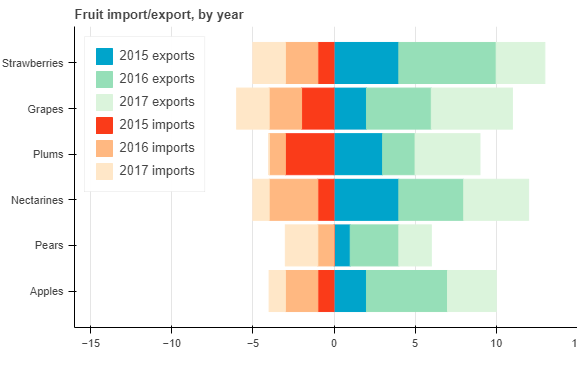

In [195]:
from bokeh.models import ColumnDataSource
from bokeh.palettes import GnBu3, OrRd3
from bokeh.plotting import figure, show

fruits = ['Apples', 'Pears', 'Nectarines', 'Plums', 'Grapes', 'Strawberries']
years = ["2015", "2016", "2017"]

exports = {'fruits' : fruits,
           '2015'   : [2, 1, 4, 3, 2, 4],
           '2016'   : [5, 3, 4, 2, 4, 6],
           '2017'   : [3, 2, 4, 4, 5, 3]}
imports = {'fruits' : fruits,
           '2015'   : [-1, 0, -1, -3, -2, -1],
           '2016'   : [-2, -1, -3, -1, -2, -2],
           '2017'   : [-1, -2, -1, 0, -2, -2]}

p = figure(y_range=fruits, height=350, x_range=(-16, 16), title="Fruit import/export, by year",
           toolbar_location=None)

p.hbar_stack(years, y='fruits', height=0.9, color=GnBu3, source=ColumnDataSource(exports),
             legend_label=["%s exports" % x for x in years])

p.hbar_stack(years, y='fruits', height=0.9, color=OrRd3, source=ColumnDataSource(imports),
             legend_label=["%s imports" % x for x in years])

p.y_range.range_padding = 0.1
p.ygrid.grid_line_color = None
p.legend.location = "top_left"
p.axis.minor_tick_line_color = None
p.outline_line_color = None

show(p)